### Aquiring and classifying daytime Landsat 8  Imagery for Burundi
The Descartes Labs API delivers a variety of image products, including Landsat8 Data: http://descartes-labs-python.readthedocs.io/en/latest/api.html

We will use satellite day and night time from 2017. Burundi's dry season spans June to late September. Imagery will be collected as close to August 15th, 2017 to minimize noise created from seasonality between the datasets and increase the likelhood the images will be cloud free.

In [1]:
import os
import warnings
from pprint import pprint

In [2]:
import descarteslabs as dl

In [3]:
# *************FIND COUNTRY BOUNDARY ***************
matches = dl.places.find('burundi')
aoi = matches[0]
pprint(aoi)

# This area of interest just gives us some basic properties such as bounding boxes.
# To access a GeoJSON Geometry object of that place, we call the `Places.shape` method, in this case
# accessing a low-resolution version of this particular shape.
shape = dl.places.shape(aoi['slug'], geom='low')

{'bbox': [29.001302, -4.468538, 30.849959, -2.309987],
 'id': 85632285,
 'name': 'Burundi',
 'path': 'continent:africa_country:burundi',
 'placetype': 'country',
 'slug': 'africa_burundi'}


Through visual inspection, I identified the best images to mosaic from the subset. 

In [4]:
north_east = 'landsat:LC08:01:RT:TOAR:meta_LC08_L1TP_172062_20170701_20170701_01_RT_v1'
south_east = 'landsat:LC08:01:RT:TOAR:meta_LC08_L1TP_172063_20170701_20170701_01_RT_v1'
north_west = 'landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_173062_20170606_20170616_01_T1_v1'
south_west = 'landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_173063_20170606_20170616_01_T1_v1'
ids = [south_east,south_west, north_east,north_west]

For visualization:

In [29]:
viz_arr, viz_meta = dl.raster.ndarray(
    ids,
    bands=['red', 'green', 'blue', 'alpha'],
    scales=[[0,4000], [0, 4000], [0, 4000], None],
    data_type='Byte',
    resolution=60,
    cutline=shape['geometry']
)

# Note: A value of 1 in the alpha channel signifies where there is valid data.
# We use this throughout the majority of our imagery as a standard way of specifying
# valid or nodata regions. This is particularly helpful if a value of 0 in a particular
# band has meaning, rather than specifying a lack of data.

For analysis:

In [5]:
arr, meta = dl.raster.ndarray(
    ids,
    bands=['red', 'green', 'blue', 'alpha'],
    scales=[[0,4000], [0, 4000], [0, 4000], None],
    data_type='Float32',
    resolution=60,
    cutline=shape['geometry']
)

In [ ]:
dl.raster.get_bands_by_key('landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_173063_20170606_20170616_01_T1_v1')

In [ ]:
exposure.histogram(arr)

In [22]:
# We'll use matplotlib to make a quick plot of the image.
import matplotlib.pyplot as plt
%matplotlib inline

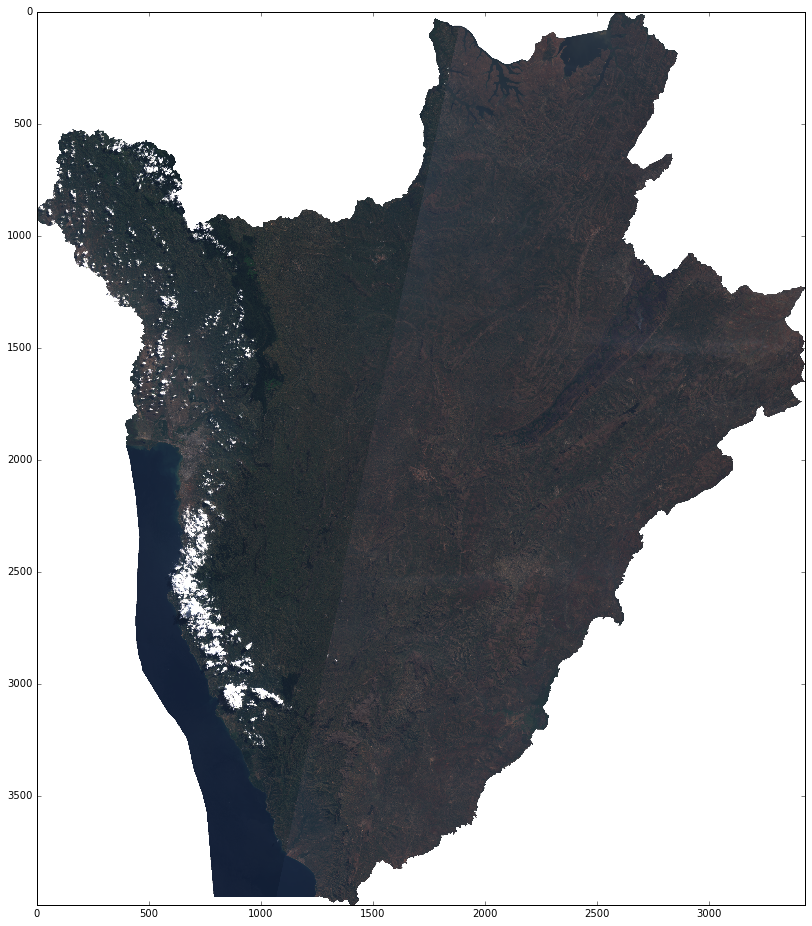

In [12]:
plt.figure(figsize=[16,16])
plt.imshow(viz_arr)

### Image Segmentation

In [6]:
%matplotlib notebook

import numpy as np
import os
import scipy

from matplotlib import pyplot as plt
from matplotlib import colors
from osgeo import gdal
from skimage import exposure
from skimage.segmentation import quickshift, felzenszwalb

Return image after stretching or shrinking its intensity levels. The following segmentation methods expect values between 0 and 1. 

In [7]:
img = exposure.rescale_intensity(arr)

#### Quickshift Clustering

In [ ]:
segments_quick = quickshift(img, kernel_size=7, max_dist=3, ratio=0.35, convert2lab=False)
n_segments = len(np.unique(segments_quick))
print(n_segments)

In [ ]:
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))

plt.figure(figsize=[16,16])
plt.imshow(segments_quick, interpolation='none', cmap=cmap)

#### Felzenszwalb Graph Based Image Segmentation

In [8]:
band_segmentation = []
for i in range(4):
    band_segmentation.append(felzenszwalb(img[:, :, i], scale=85, sigma=0.25, min_size=9))

In [9]:
const = [b.max() + 1 for b in band_segmentation]
segmentation = band_segmentation[0]
for i, s in enumerate(band_segmentation[1:]):
    segmentation += s * np.prod(const[:i+1])

_, labels = np.unique(segmentation, return_inverse=True)
segments_felz = labels.reshape(img.shape[:2])

<IPython.core.display.Javascript object>


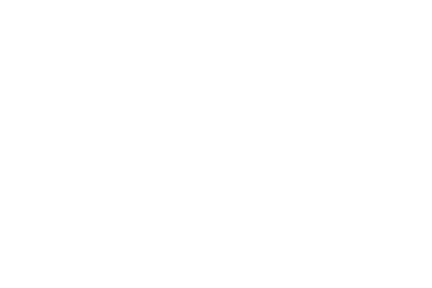

<IPython.core.display.Javascript object>


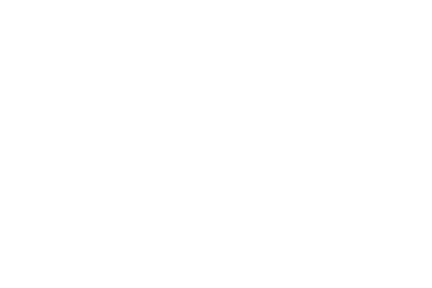

In [17]:
cmap = colors.ListedColormap(np.random.rand(len(np.unique(segments_felz)), 3))
plt.figure()
plt.imshow(segments_felz, interpolation='none', cmap=cmap)

In [10]:
# We choose the quick segmentation
segments = segments_felz
segment_ids = np.unique(segments)
print("Felzenszwalb segmentation. %i segments." % len(segment_ids))

Felzenszwalb segmentation. 202121 segments.


#### Original, Quickshift segmentation, and Felzenszwalb segmentation plotted

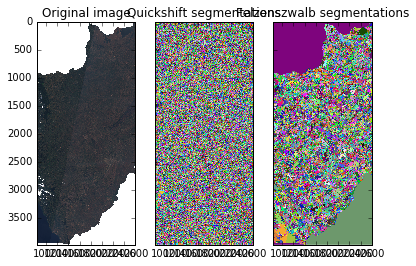

In [23]:
n_segments = max(len(np.unique(s)) for s in [segments_quick, segments_felz])
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))
#SHOW_IMAGES:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.imshow(viz_arr, interpolation='none')
ax1.set_title('Original image')
ax2.imshow(segments_quick, interpolation='none', cmap=cmap)
ax2.set_title('Quickshift segmentations')
ax3.imshow(segments_felz, interpolation='none', cmap=cmap)
ax3.set_title('Felzenszwalb segmentations')
plt.show()

The rest of the program uses the results of the Felzenszwalb segmentation

### Train Classification Model

Begin by bringing in previously identified training data. This vector dataset are the labels used to train the classification algorithm.

In [11]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

TRAIN_DATA_PATH = "data/landsat/train/"
# TEST_DATA_PATH = "data/test/"

Create a few helper methods to transform training and test data to raster format for analysis:

In [12]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize all the vectors in the given directory into a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels

In [13]:
rows, cols, n_bands = img.shape
files = [f for f in os.listdir(TRAIN_DATA_PATH) if f.endswith('.shp')]
classes_labels = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(TRAIN_DATA_PATH, f) for f in files if f.endswith('.shp')]
print(shapefiles)

['data/landsat/train/water_train.shp', 'data/landsat/train/cloud_train.shp', 'data/landsat/train/forest_train.shp', 'data/landsat/train/wetland_train.shp', 'data/landsat/train/urban_train.shp', 'data/landsat/train/bareground_train.shp', 'data/landsat/train/scrubland_train.shp']


Derive metadata information from Landsat imagery.

In [14]:
geo_transform = meta['geoTransform']
proj = meta['coordinateSystem']['wkt']

In [15]:
ground_truth = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)

In [16]:
classes = np.unique(ground_truth)[1:]  # 0 doesn't count
len(classes)

7

In [17]:
segments_per_klass = {}
for klass in classes:
    segments_of_klass = segments[ground_truth==klass]
    segments_per_klass[klass] = set(segments_of_klass)
    print("Training segments for class %i: %i" % (klass, len(segments_per_klass[klass])))

Training segments for class 1: 13
Training segments for class 2: 17
Training segments for class 3: 12
Training segments for class 4: 14
Training segments for class 5: 30
Training segments for class 6: 12
Training segments for class 7: 47


Check for segments which contain conflicting training data:

In [ ]:
accum = set()
intersection = set()
for class_segments in segments_per_klass.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0

Next, we will paint in black all segments that are not for training. The training segments will be painted of a color depending on the class.

To do that we'll set as threshold the max segment id (max segments image pixel value). Then, to the training segments we'll assign values higher than the threshold. Finally, we assign 0 (zero) to pixels with values equal or below the threshold.

In [18]:
train_img = np.copy(segments)
threshold = train_img.max() + 1
for klass in classes:
    klass_label = threshold + klass
    for segment_id in segments_per_klass[klass]:
        train_img[train_img == segment_id] = klass_label
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

#### Plot the training segments

<IPython.core.display.Javascript object>


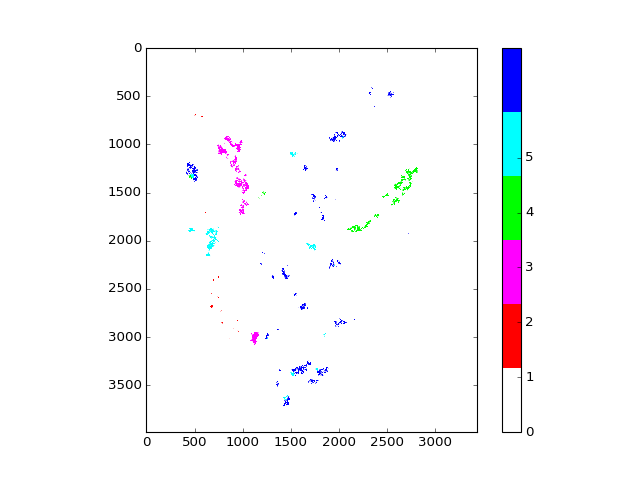

In [20]:
plt.figure()
cm = np.array([[ 1,  1,  1 ], [ 1,0,0], [ 1,0,1], [ 0,1,0], [ 0,1,1], [ 0,0,1]])
cmap = colors.ListedColormap(cm)
plt.imshow(train_img, cmap=cmap)
plt.colorbar(ticks=[0,1,2,3,4,5])

So now, we transform each training segment into a segment model and thus creating the training dataset.

In [ ]:
def segment_features(segment_pixels):
    """For each band, compute: min, max, mean, variance, skewness, kurtosis"""
    features = []
    n_pixels, n_bands = segment_pixels.shape
    for b in range(n_bands):
        stats = scipy.stats.describe(segment_pixels[:,b])
#         print(len(stats))
#         print(stats)
#         band_stats = list(stats.minmax)
#         print(stats.minmax)
#         print(stats[0])
#         print(stats[1])
#         print("Investigation")
        band_stats = list(stats.minmax) + list(stats)[2:]
        print(band_stats)
#         if n_pixels == 1:
            # scipy.stats.describe raises a Warning and sets variance to nan
#             band_stats[3] = 0.0  # Replace nan with something (zero)
#         features += band_stats
#     return features

In [19]:
def segment_features(segment_pixels):
    """For each band, compute: min, max, mean, variance, skewness, kurtosis"""
    features = []
    n_pixels, n_bands = segment_pixels.shape
    for b in range(n_bands):
        stats = scipy.stats.describe(segment_pixels[:,b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if n_pixels == 1:
            # scipy.stats.describe raises a Warning and sets variance to nan
            band_stats[3] = 0.0  # Replace nan with something (zero)
        features += band_stats
    return features

#### Create all the objects:
compute the features' vector for each segment (and append the segment ID as reference)

In [20]:
# This is the most heavy part of the process. It could take about half an hour to finish in a not-so-fast CPU
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    objects = []
    objects_ids = []
    for segment_label in segment_ids:
        segment_pixels = img[segments==segment_label]
        segment_model = segment_features(segment_pixels)
        objects.append(segment_model)
        
        # Keep a reference to the segment label
        objects_ids.append(segment_label)  

    print("Created %i objects" % len(objects))

Created 202121 objects


#### Subset the training data

In [21]:
training_labels = []
training_objects = []
for klass in classes:
    class_train_objects = [v for i, v in enumerate(objects) if objects_ids[i] in segments_per_klass[klass]]
    training_labels += [klass] * len(class_train_objects)
    print("Training samples for class %i: %i" % (klass, len(class_train_objects)))
    training_objects += class_train_objects

Training samples for class 1: 13
Training samples for class 2: 17
Training samples for class 3: 12
Training samples for class 4: 14
Training samples for class 5: 30
Training samples for class 6: 12
Training samples for class 7: 47


#### Train a classifier

In [22]:
classifier = RandomForestClassifier(n_jobs=-1)

In [23]:
classifier.fit(training_objects, training_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Classify all segments

Now we have to transform all segments into segment models in order to classify them. 

In [24]:
predicted = classifier.predict(objects)

### Propagate the classification

Now that each segment has been classified, we need to propagate that classification to the pixel level. That is, given the class k for the segment with label S, generate a classification from the segmented image where all pixels in segment S are assigned the class k.

In [25]:
clf = np.copy(segments)

In [26]:
for segment_id, klass in zip(objects_ids, predicted):
    clf[clf==segment_id] = klass

<IPython.core.display.Javascript object>


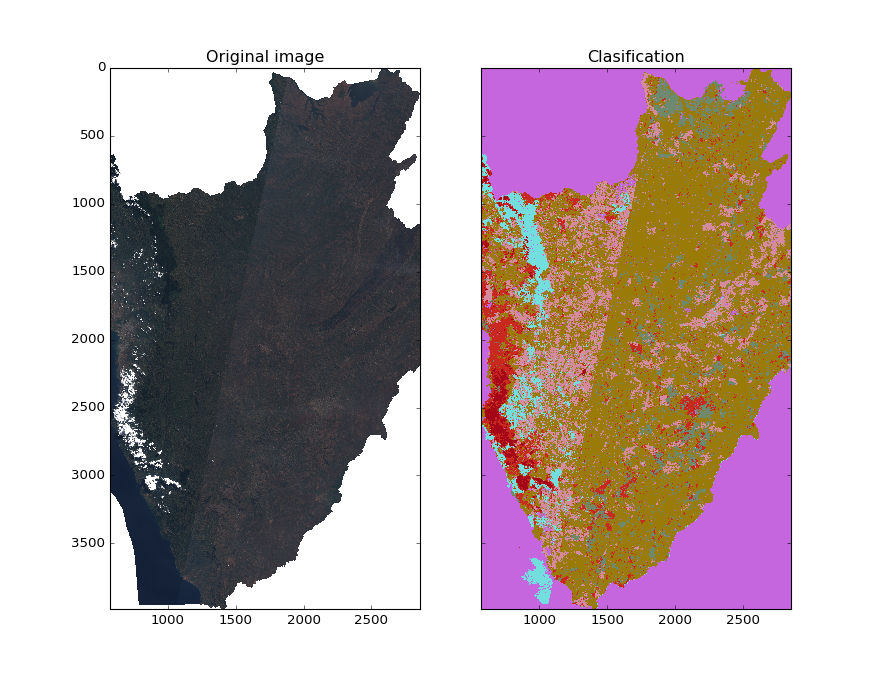

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(viz_arr, interpolation='none')
ax1.set_title('Original image')
ax2.imshow(clf, interpolation='none', cmap=colors.ListedColormap(np.random.rand(len(classes_labels), 3)))
ax2.set_title('Clasification')

<IPython.core.display.Javascript object>


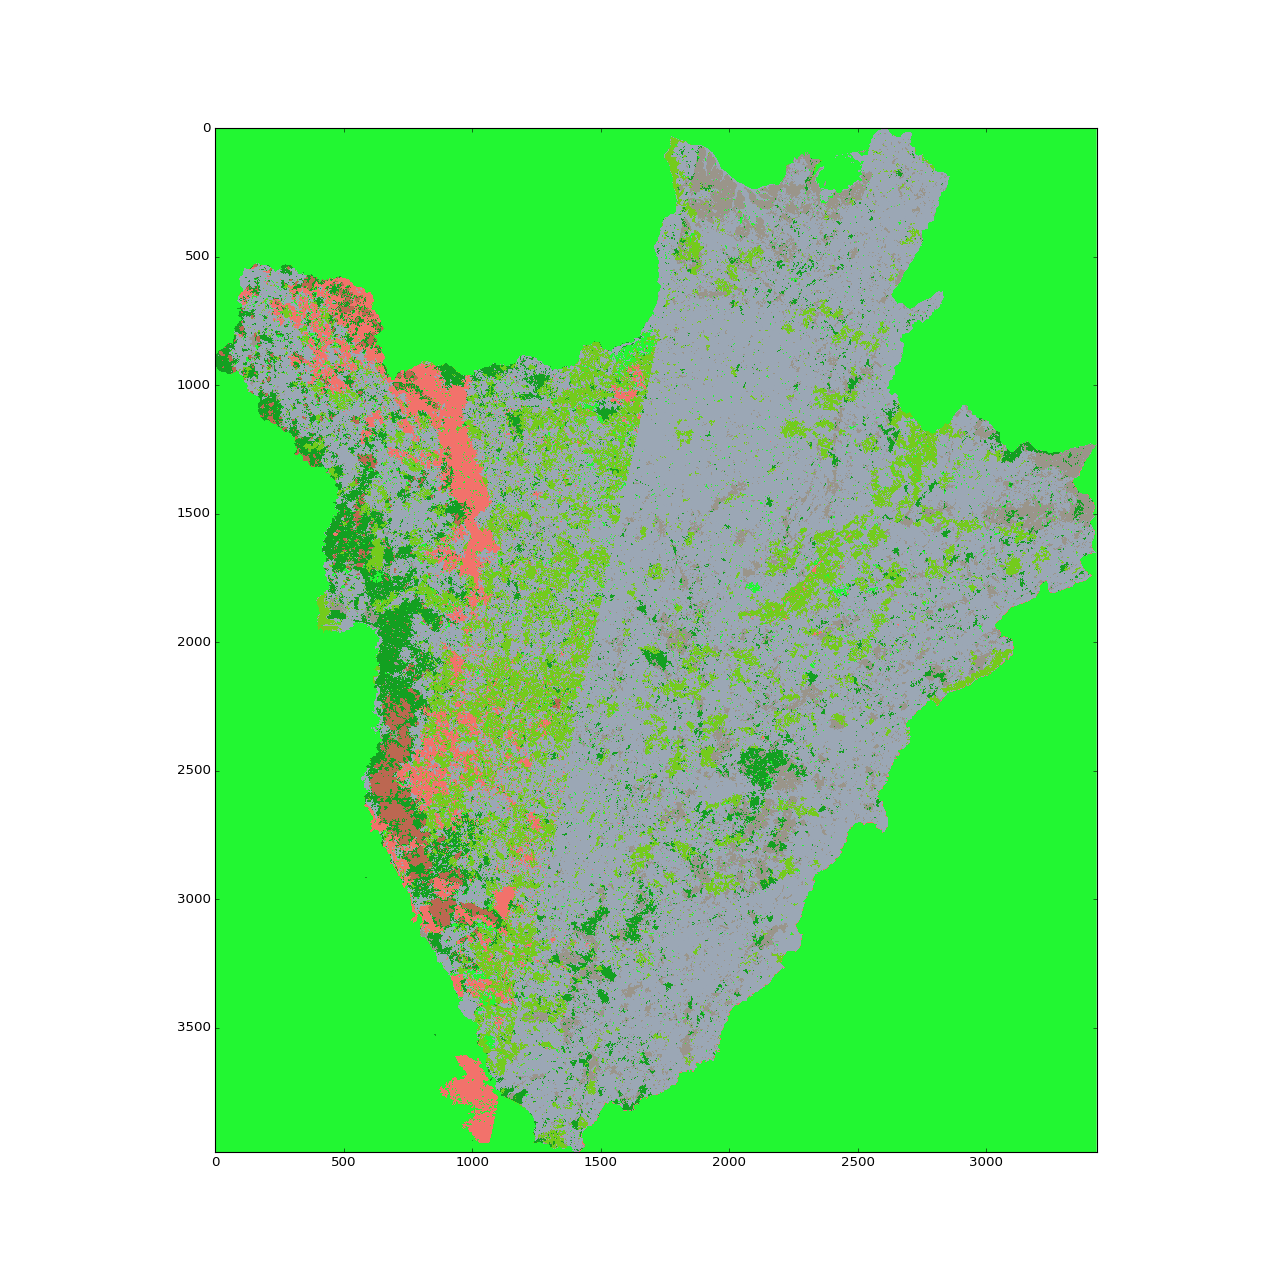

In [32]:
plt.figure(figsize=[16,16])
plt.imshow(clf, interpolation='none', cmap=colors.ListedColormap(np.random.rand(len(classes_labels), 3)))
